In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [12]:
df = pd.read_csv('Transformed_dataset.csv')

In [13]:
df['Shortage'] = df['Total_Consumption'] - df['Total_Generation']

In [14]:
df

,Date_Timestamp,DayOfWeek,Month,HourOfDay,Consumption_B1,Consumption_B2,Consumption_B3,Generation_1,Generation_2,Generation_3,...,Temperature (c),relative_humidity_2m (%),dew_point_2m (¬∞C),precipitation (mm),cloud_cover (%),Cloud_Cover_Category,wind_speed_10m (km/h),Total_Consumption,Total_Generation,Shortage
0,2019-01-01 00:30:00,1,1,0,263.934730,119.965555,100.382488,0.0,0.0,0.0,...,0.24,87,-1.7,0.0,56,Partly Cloudy,7.2,484.282773,0.0,484.282773
1,2019-01-01 01:30:00,1,1,1,261.381617,126.873583,98.777157,0.0,0.0,0.0,...,0.33,87,-1.6,0.0,100,Overcast,7.6,487.032358,0.0,487.032358
2,2019-01-01 02:30:00,1,1,2,289.598378,130.980467,109.956200,0.0,0.0,0.0,...,0.36,88,-1.5,0.0,94,Overcast,5.9,530.535045,0.0,530.535045
3,2019-01-01 03:30:00,1,1,3,340.806009,143.535150,129.512557,0.0,0.0,0.0,...,0.21,88,-1.6,0.0,88,Overcast,5.5,613.853717,0.0,613.853717
4,2019-01-01 04:30:00,1,1,4,399.536718,174.588548,150.485312,0.0,0.0,0.0,...,0.03,88,-1.7,0.0,81,Overcast,6.4,724.610577,0.0,724.610577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2020-12-31 19:30:00,3,12,19,240.822001,185.668900,97.548156,0.0,0.0,0.0,...,2.44,99,2.2,0.0,35,Mostly Clear,4.6,524.039056,0.0,524.039056
17516,2020-12-31 20:30:00,3,12,20,225.928331,178.478517,92.432246,0.0,0.0,0.0,...,1.91,100,1.8,0.0,45,Partly Cloudy,4.8,496.839094,0.0,496.839094
17517,2020-12-31 21:30:00,3,12,21,200.289301,164.246147,83.005720,0.0,0.0,0.0,...,1.51,100,1.4,0.0,35,Mostly Clear,4.7,447.541168,0.0,447.541168
17518,2020-12-31 22:30:00,3,12,22,184.485978,145.000653,80.381694,0.0,0.0,0.0,...,1.44,99,1.2,0.0,39,Mostly Clear,5.8,409.868325,0.0,409.868325


In [17]:
# Define the MAPE function
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
X_Shortage = df.drop(['Date_Timestamp','Total_Consumption', 'Total_Generation','Consumption_B2','Consumption_B3','Generation_1','Generation_3','Shortage','Cloud_Cover_Category'], axis=1)
y_Shortage = df['Shortage']

# Split the data into training and testing sets
X_train_Shortage, X_test_Shortage, y_train_Shortage, y_test_Shortage = train_test_split(X_Shortage, y_Shortage, test_size=0.042, random_state=42, shuffle=False)

In [35]:
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1]
}

# Initialize the XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgbr, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error')

# Fit the XGBoost model with the training data
grid_search_xgb.fit(X_train_Shortage, y_train_Shortage)

# Get the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_
print("Best XGBoost Hyperparameters:", best_params_xgb)

# Use the best XGBoost model for prediction
best_xgb_model_Shortage = grid_search_xgb.best_estimator_
y_pred_xgb_Shortage = best_xgb_model_Shortage.predict(X_test_Shortage)

# Evaluate the XGBoost model
rmse_xgb = np.sqrt(mean_squared_error(y_test_Shortage, y_pred_xgb_Shortage))
print(f"XGBoost RMSE: {rmse_xgb}")

mae_xgb = mean_absolute_error(y_test_Shortage, y_pred_xgb_Shortage)
print(f"XGBoost MAE: {mae_xgb}")

mape_xgb = calculate_mape(y_test_Shortage, y_pred_xgb_Shortage)
print(f"XGBoost MAPE: {mape_xgb:.2f}%")

Best XGBoost Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost RMSE: 79.08638678559751
XGBoost MAE: 45.88151740137265
XGBoost MAPE: 45.08%


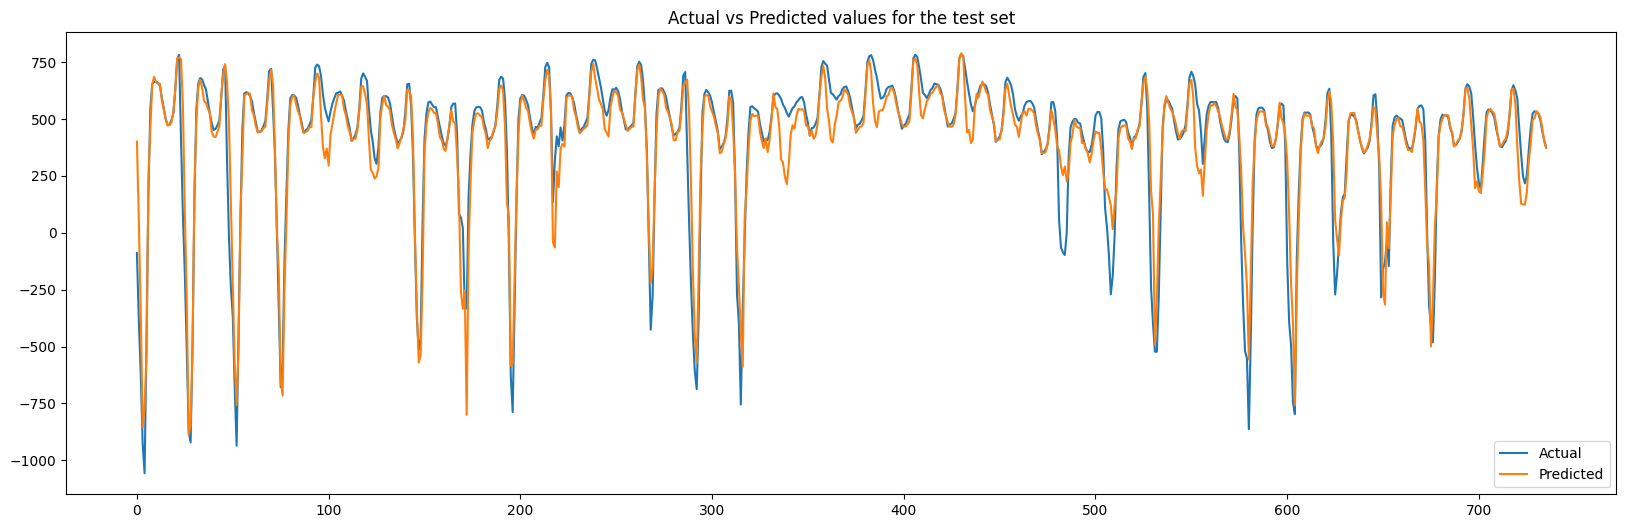

In [33]:
#Plotting the actual vs predicted values for the test set
plt.figure(figsize=(20, 6))
y_test1_consumption = y_test_Shortage.to_numpy()
plt.plot(y_test1_consumption, label='Actual')
plt.plot(y_pred_xgb_Shortage, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted values for the test set")
plt.show()

In [37]:
df1 = df

In [39]:
df1.head(20)

,Date_Timestamp,DayOfWeek,Month,HourOfDay,Consumption_B1,Consumption_B2,Consumption_B3,Generation_1,Generation_2,Generation_3,...,Temperature (c),relative_humidity_2m (%),dew_point_2m (¬∞C),precipitation (mm),cloud_cover (%),Cloud_Cover_Category,wind_speed_10m (km/h),Total_Consumption,Total_Generation,Shortage
0,2019-01-01 00:30:00,1,1,0,263.934730,119.965555,100.382488,0.000000,0.000000,0.000000,...,0.24,87,-1.7,0.0,56,Partly Cloudy,7.2,484.282773,0.000000,484.282773
1,2019-01-01 01:30:00,1,1,1,261.381617,126.873583,98.777157,0.000000,0.000000,0.000000,...,0.33,87,-1.6,0.0,100,Overcast,7.6,487.032358,0.000000,487.032358
2,2019-01-01 02:30:00,1,1,2,289.598378,130.980467,109.956200,0.000000,0.000000,0.000000,...,0.36,88,-1.5,0.0,94,Overcast,5.9,530.535045,0.000000,530.535045
3,2019-01-01 03:30:00,1,1,3,340.806009,143.535150,129.512557,0.000000,0.000000,0.000000,...,0.21,88,-1.6,0.0,88,Overcast,5.5,613.853717,0.000000,613.853717
4,2019-01-01 04:30:00,1,1,4,399.536718,174.588548,150.485312,0.000000,0.000000,0.000000,...,0.03,88,-1.7,0.0,81,Overcast,6.4,724.610577,0.000000,724.610577
5,2019-01-01 05:30:00,1,1,5,359.570304,251.327078,135.929211,0.000000,0.000000,0.000000,...,-0.49,91,-1.9,0.0,67,Mostly Cloudy,5.1,746.826593,0.000000,746.826593
6,2019-01-01 06:30:00,1,1,6,352.059444,247.050640,147.602814,0.000000,0.000000,0.000000,...,-0.56,90,-2.1,0.0,75,Mostly Cloudy,4.8,746.712898,0.000000,746.712898
7,2019-01-01 07:30:00,1,1,7,344.880960,239.038966,147.823253,0.000000,0.650407,0.000000,...,0.05,90,-1.5,0.0,86,Overcast,3.2,731.743179,0.650407,731.092773
8,2019-01-01 08:30:00,1,1,8,329.569168,237.915318,135.971290,14.358974,254.634146,17.341256,...,-0.19,92,-1.4,0.0,89,Overcast,4.3,703.455776,286.334376,417.121400
9,2019-01-01 09:30:00,1,1,9,314.838795,230.916968,129.750366,70.618401,644.552846,85.285463,...,0.43,88,-1.3,0.0,80,Mostly Cloudy,4.2,675.506128,800.456710,-124.950582


In [42]:
def assign_severity(value):
    if value > 100:
        return 'High Severity'
    elif value < 0:
        return 'Abundance'
    else:
        return 'Low Severity'

# Apply the function to create a new column with severity categories
df1['severity'] = df1['Shortage'].apply(assign_severity)

df1.head(20)

,Date_Timestamp,DayOfWeek,Month,HourOfDay,Consumption_B1,Consumption_B2,Consumption_B3,Generation_1,Generation_2,Generation_3,...,relative_humidity_2m (%),dew_point_2m (¬∞C),precipitation (mm),cloud_cover (%),Cloud_Cover_Category,wind_speed_10m (km/h),Total_Consumption,Total_Generation,Shortage,severity
0,2019-01-01 00:30:00,1,1,0,263.934730,119.965555,100.382488,0.000000,0.000000,0.000000,...,87,-1.7,0.0,56,Partly Cloudy,7.2,484.282773,0.000000,484.282773,High Severity
1,2019-01-01 01:30:00,1,1,1,261.381617,126.873583,98.777157,0.000000,0.000000,0.000000,...,87,-1.6,0.0,100,Overcast,7.6,487.032358,0.000000,487.032358,High Severity
2,2019-01-01 02:30:00,1,1,2,289.598378,130.980467,109.956200,0.000000,0.000000,0.000000,...,88,-1.5,0.0,94,Overcast,5.9,530.535045,0.000000,530.535045,High Severity
3,2019-01-01 03:30:00,1,1,3,340.806009,143.535150,129.512557,0.000000,0.000000,0.000000,...,88,-1.6,0.0,88,Overcast,5.5,613.853717,0.000000,613.853717,High Severity
4,2019-01-01 04:30:00,1,1,4,399.536718,174.588548,150.485312,0.000000,0.000000,0.000000,...,88,-1.7,0.0,81,Overcast,6.4,724.610577,0.000000,724.610577,High Severity
5,2019-01-01 05:30:00,1,1,5,359.570304,251.327078,135.929211,0.000000,0.000000,0.000000,...,91,-1.9,0.0,67,Mostly Cloudy,5.1,746.826593,0.000000,746.826593,High Severity
6,2019-01-01 06:30:00,1,1,6,352.059444,247.050640,147.602814,0.000000,0.000000,0.000000,...,90,-2.1,0.0,75,Mostly Cloudy,4.8,746.712898,0.000000,746.712898,High Severity
7,2019-01-01 07:30:00,1,1,7,344.880960,239.038966,147.823253,0.000000,0.650407,0.000000,...,90,-1.5,0.0,86,Overcast,3.2,731.743179,0.650407,731.092773,High Severity
8,2019-01-01 08:30:00,1,1,8,329.569168,237.915318,135.971290,14.358974,254.634146,17.341256,...,92,-1.4,0.0,89,Overcast,4.3,703.455776,286.334376,417.121400,High Severity
9,2019-01-01 09:30:00,1,1,9,314.838795,230.916968,129.750366,70.618401,644.552846,85.285463,...,88,-1.3,0.0,80,Mostly Cloudy,4.2,675.506128,800.456710,-124.950582,Abundance


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load your sample DataFrame
# Assuming your DataFrame is already loaded and named df1

# Define features (X) and target variable (y)
X_shortage = df1.drop(['Date_Timestamp','Total_Consumption', 'Total_Generation','Consumption_B1','Consumption_B2','Consumption_B3','Generation_2','Generation_1','Generation_3','Shortage','Cloud_Cover_Category', 'severity'], axis=1)
y_shortage = df1['severity']

# Label encoding for target variable y
label_encoder = LabelEncoder()
y_shortage_encoded = label_encoder.fit_transform(y_shortage)

# Split the data into training and testing sets
X_train_shortage, X_test_shortage, y_train_shortage, y_test_shortage = train_test_split(X_shortage, y_shortage_encoded, test_size=0.042, random_state=42, shuffle=False)

# Random Forest classifier
rf = RandomForestClassifier()

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

from sklearn.model_selection import StratifiedKFold

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search Cross Validation with stratified K-fold
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=cv, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train_shortage, y_train_shortage)

# Best parameters
print("Best parameters found:", rf_random.best_params_)

# Evaluate the model
y_pred_shortage = rf_random.predict(X_test_shortage)

# Decode predictions
y_pred_shortage_decoded = label_encoder.inverse_transform(y_pred_shortage)

# Accuracy
accuracy_shortage = accuracy_score(y_test_shortage, y_pred_shortage)
print("Accuracy:", accuracy_shortage)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_shortage, y_pred_shortage, target_names=label_encoder.classes_))



Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   3.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END max_dep

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [52]:
from sklearn.metrics import confusion_matrix

# Evaluate the model
y_pred_shortage = rf_random.predict(X_test_shortage)

# Decode predictions
y_pred_shortage_decoded = label_encoder.inverse_transform(y_pred_shortage)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_shortage, y_pred_shortage)

print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy_shortage = accuracy_score(y_test_shortage, y_pred_shortage)
print("Accuracy:", accuracy_shortage)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_shortage, y_pred_shortage, target_names=label_encoder.classes_))


Confusion Matrix:
[[ 23  59   0]
 [  5 635   0]
 [  3  11   0]]
Accuracy: 0.8940217391304348
Classification Report:
               precision    recall  f1-score   support

    Abundance       0.74      0.28      0.41        82
High Severity       0.90      0.99      0.94       640
 Low Severity       0.00      0.00      0.00        14

     accuracy                           0.89       736
    macro avg       0.55      0.42      0.45       736
 weighted avg       0.87      0.89      0.87       736



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [53]:
# Predicted scores
y_scores = rf_random.predict_proba(X_test_shortage)

# Convert predicted labels back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred_shortage)

# Actual labels
y_actual_labels = label_encoder.inverse_transform(y_test_shortage)

# Create a DataFrame to display actual vs predicted labels and scores
results_df = pd.DataFrame({'Actual_Label': y_actual_labels,
                           'Predicted_Label': y_pred_labels,
                           'Actual_Score': y_scores.max(axis=1),
                           'Predicted_Score': [score[label_encoder.transform([label])[0]] for score, label in zip(y_scores, y_pred_labels)]})

# Display the DataFrame
print("Actual vs Predicted:")
print(results_df)


Actual vs Predicted:
      Actual_Label Predicted_Label  Actual_Score  Predicted_Score
0        Abundance   High Severity      0.933333         0.933333
1        Abundance   High Severity      0.840000         0.840000
2        Abundance   High Severity      0.606667         0.606667
3        Abundance       Abundance      0.586667         0.586667
4        Abundance       Abundance      0.500000         0.500000
..             ...             ...           ...              ...
731  High Severity   High Severity      0.993333         0.993333
732  High Severity   High Severity      1.000000         1.000000
733  High Severity   High Severity      0.986667         0.986667
734  High Severity   High Severity      0.986667         0.986667
735  High Severity   High Severity      0.966667         0.966667

[736 rows x 4 columns]


In [54]:
# Calculate correct predictions
correct_predictions = (y_pred_shortage == y_test_shortage).sum()

# Calculate total predictions
total_predictions = len(y_test_shortage)

# Calculate incorrect predictions
incorrect_predictions = total_predictions - correct_predictions

print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", incorrect_predictions)


Correct predictions: 658
Incorrect predictions: 78
